# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

- Teste com redes neurais multicamadas (MLP)
- Se gostou ou achou útil, up-vote!! :)

**Versão 1.0.0: LB = 0.50744 / CV = ???**
- modelo: NN com 3 camadas
- features categoricas: removido
- dados missing: atribuído o valor medio
- feature selection: 25

**Versão 1.0.1: LB = 0.52913 / CV = 0.471703**
- modelo: NN com 3 camadas ocultas
- dados missing: removido colunas com mais de 50% de NA e as demais usei a média
- features categoricas: label encoder
- feature engineering: usando pacote Boruta (dica do Allyson)

**Versão 1.0.2: LB = ??? / CV = 0.472390**
- modelo: NN com 3 camadas ocultas
- features engineering: Kernel_Feature_Engineering_v.1.0.0

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
import re
import random as rd
import os
import codecs
import time
import datetime
import gc
from numba import jit
from collections import Counter
import copy
from typing import Any

seed = 12345
np.random.seed(seed)
rd.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb 

# Importa os pacotes de algoritmos de redes neurais (Keras)
import keras
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import keras.backend as K
from keras.optimizers import Adam
from keras import optimizers
from keras.utils import np_utils

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as TTS

from keras.callbacks import ReduceLROnPlateau as RLRP
from keras.callbacks import EarlyStopping as ES

Using TensorFlow backend.


# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino_new.csv....')
        train = pd.read_csv('../dataset/dataset_treino_new.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

        print('Carregando arquivo dataset_teste_new.csv....')
        test = pd.read_csv('../dataset/dataset_teste_new.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))

        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino_new.csv....
dataset_treino.csv tem 114321 linhas and 184 colunas
Carregando arquivo dataset_teste_new.csv....
dataset_teste.csv tem 114393 linhas and 183 colunas


In [5]:
# Leitura dos dados
train, test = read_data()
df = train.append(test)
df = df.drop(columns = ['1'], axis = 1)

Carregando arquivo dataset_treino_new.csv....
dataset_treino.csv tem 114321 linhas and 184 colunas
Carregando arquivo dataset_teste_new.csv....
dataset_teste.csv tem 114393 linhas and 183 colunas


In [6]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"]
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  164
Number of Categorical features:  19


In [7]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))

# Feature Engineering

In [8]:
new_df = df.copy()

In [9]:
# Create correlation matrix
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['grp_5',
 'grp_8',
 'pca_1',
 'srp_12',
 'srp_2',
 'srp_4',
 'srp_5',
 'srp_8',
 'tsvd_1',
 'tsvd_2',
 'tsvd_6',
 'tsvd_7',
 'tsvd_8',
 'tsvd_9',
 'v114',
 'v119 v123',
 'v119 v48',
 'v119 v85',
 'v119^2',
 'v119_x',
 'v119_y',
 'v123 v48',
 'v123 v85',
 'v123^2',
 'v123_x',
 'v123_y',
 'v40',
 'v48 v85',
 'v48^2',
 'v48_x',
 'v48_y',
 'v58',
 'v62 v48',
 'v62_x',
 'v62_y',
 'v69',
 'v75',
 'v85_x',
 'v85_y']

In [10]:
# Drop features 
new_df = new_df.drop(new_df[to_drop], axis=1)
new_df.shape

(228714, 144)

In [11]:
# Separar o dataset de treino e teste
treino = new_df[new_df['target'].notnull()]
teste  = new_df[new_df['target'].isnull()]

# Feature Selection

In [12]:
# Importância do Atributo com o Random Forest Regressor
X_ = treino.drop(['ID','target'], axis=1)
y_ = treino['target']

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
scaler = StandardScaler()
X_ = scaler.fit_transform(X_)

# Criação do Modelo - Feature Selection
modeloRF = RandomForestRegressor(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(treino.drop(['ID','target'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

      Feature  importance
106       v50    0.161647
118       v66    0.055839
104       v47    0.024312
95        v31    0.022960
126       v79    0.021386
109       v56    0.017183
15      ica_3    0.017015
35     srp_11    0.016480
47        v10    0.014563
39      srp_9    0.013490
86        v22    0.013485
31      pca_8    0.012646
59       v110    0.011759
85        v21    0.011732
34     srp_10    0.011441
88        v24    0.010797
71       v125    0.010354
28      pca_5    0.009684
4       grp_2    0.009178
0       grp_1    0.008981
62       v113    0.008955
77        v14    0.008915
6       grp_4    0.008878
2      grp_11    0.008633
13     ica_12    0.008621
7       grp_6    0.008312
19      ica_7    0.008035
14      ica_2    0.008002
41    tsvd_11    0.007690
32      pca_9    0.007641
74       v129    0.007550
24     pca_12    0.007492
40    tsvd_10    0.007491
30      pca_7    0.007402
1      grp_10    0.007354
21      ica_9    0.007211
20      ica_8    0.007175
17      ica_

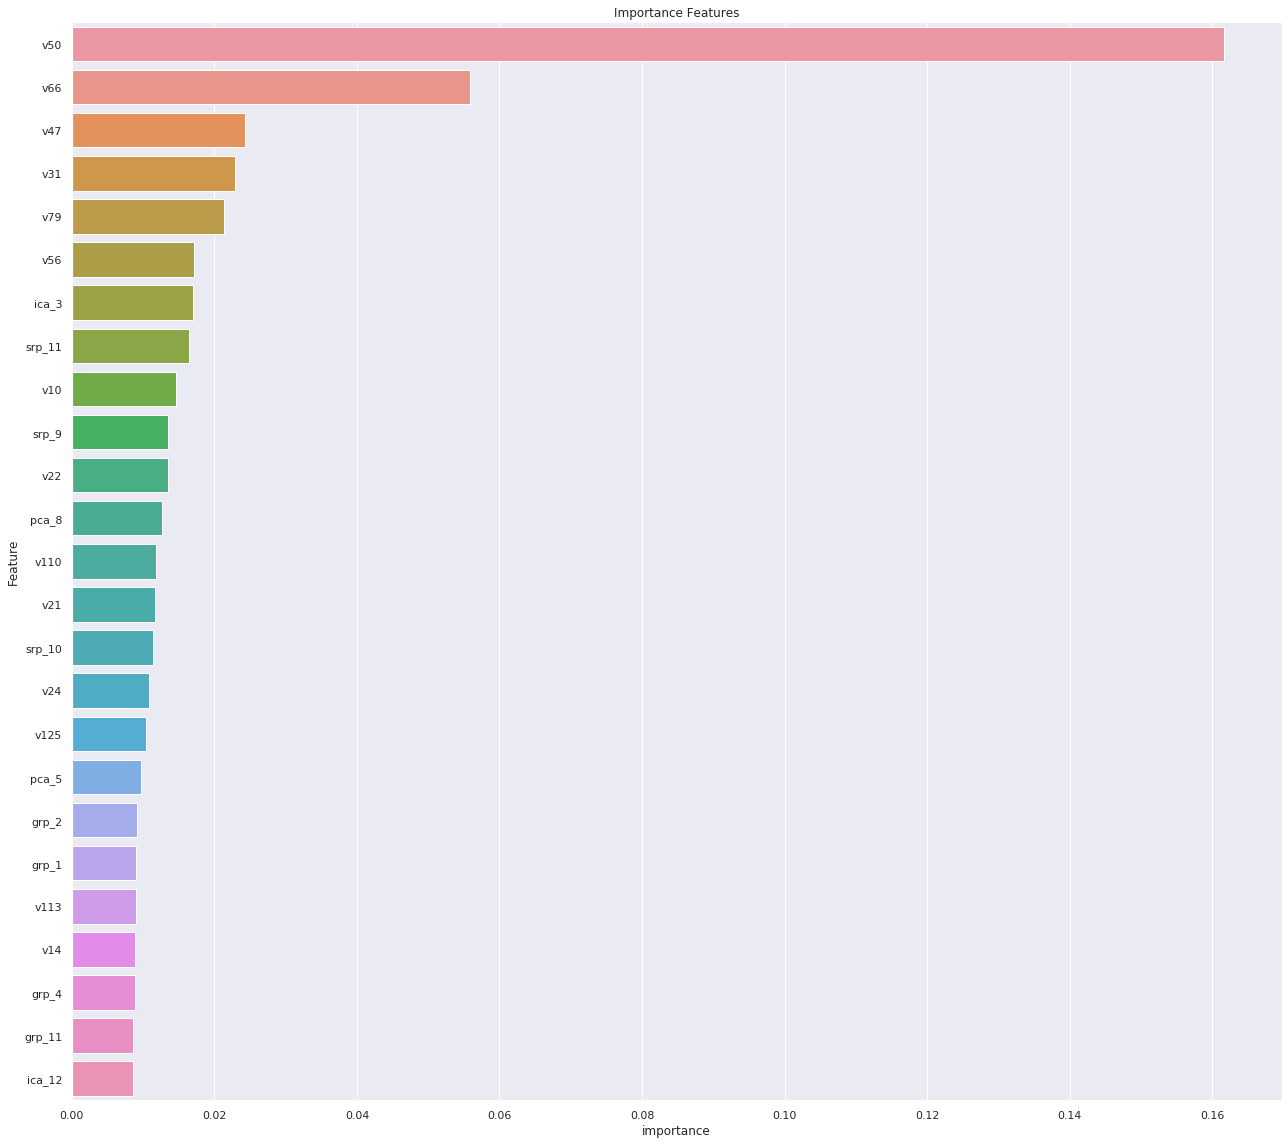

In [13]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

# Algoritmo Neural Network MLP

In [14]:
# Criar um dataset somente com as colunas mais importantes conforme Feature Selection
new_X = treino.loc[:,best_features['Feature']]

# Padronizando os dados de treino
scaler = StandardScaler()
train_x = scaler.fit_transform(new_X)

train_y = np_utils.to_categorical(treino['target'])

# Verificando o shape dos datasets depois dos ajustes
# Neste momento está pronto para ser usado pelo treinamento
train_x.shape, train_y.shape

((114321, 25), (114321, 2))

In [15]:
# Limpeza da memória
gc.collect()

6833

In [16]:
# Criando função para treinar a rede neural
def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    
    # Cria a estrutura da rede neural com 3 camadas ocultas
    inp = Input(shape = (x_tr.shape[1],))

    x = Dense(1024, input_dim=x_tr.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)    
    x = BatchNormalization()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)    
    x = BatchNormalization()(x)
    
    out = Dense(2, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = 'Adam',
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    # Realiza a parada mais cedo quando percebe overfitting
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=20)

    # Realiza checkpoint durante o treinamento
    mc = ModelCheckpoint('best_model.h5',
                         monitor='val_loss',
                         mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)

    # Realize o ajuste na Learning Rate durante o treinamento
    rl = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.1, 
                           patience=10, 
                           verbose=1, 
                           epsilon=1e-4, 
                           mode='min')

    # Realiza o fit do modelo
    model.fit(x_tr, y_tr,
              validation_data=[x_val, y_val],
              callbacks=[es,mc,rl],
              epochs=250, 
              batch_size=1024,
              verbose=1,
              shuffle=True)
    
    # Carrega os melhores pesos
    model.load_weights("best_model.h5")
    
    # Realiza as previsões
    y_pred = model.predict(x_val)
    y_valid = y_val
             
    # Calcula o log loss
    logloss = log_loss(y_valid, y_pred, eps=1e-15)

    return model, logloss

In [17]:
%%time

# Bloco para executar a rede neural a cada passada do KFold
# Vamos realizar 2 loops com 5 kfolds e apurar a média
loop = 2
fold = 5

# Definindo listas que serão preenchidas durante o loop for
oof_nn = np.zeros([loop, train_y.shape[0], train_y.shape[1]])
models_nn = []
logloss_csv_nn = []

# Treinando o modelo
for k in range(loop):
    kfold = KFold(fold, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(train_y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = train_x[tr_inds], train_y[tr_inds]
        val_x, val_y = train_x[val_inds], train_y[val_inds]
        
        # Train NN
        nn, logloss_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold Log-Loss (NN) is %f"%((k_fold+1), logloss_nn))
        logloss_csv_nn.append(logloss_nn)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)
        
    print("PARTIAL: mean Log-Loss (NN) is %f"%np.mean(logloss_csv_nn))        

-----------
Loop 1/2 Fold 1/5
-----------
Train on 91456 samples, validate on 22865 samples
Epoch 1/250
91456/91456 [==============================] - 10s 105us/step - loss: 0.6286 - categorical_accuracy: 0.6834 - val_loss: 0.5061 - val_categorical_accuracy: 0.7616

Epoch 00001: val_loss improved from inf to 0.50606, saving model to best_model.h5
Epoch 2/250
91456/91456 [==============================] - 7s 73us/step - loss: 0.5231 - categorical_accuracy: 0.7566 - val_loss: 0.4984 - val_categorical_accuracy: 0.7573

Epoch 00002: val_loss improved from 0.50606 to 0.49836, saving model to best_model.h5
Epoch 3/250
91456/91456 [==============================] - 6s 64us/step - loss: 0.5093 - categorical_accuracy: 0.7627 - val_loss: 0.4884 - val_categorical_accuracy: 0.7708

Epoch 00003: val_loss improved from 0.49836 to 0.48842, saving model to best_model.h5
Epoch 4/250
91456/91456 [==============================] - 6s 64us/step - loss: 0.5019 - categorical_accuracy: 0.7647 - val_loss: 0.4

91456/91456 [==============================] - 7s 74us/step - loss: 0.4712 - categorical_accuracy: 0.7793 - val_loss: 0.4681 - val_categorical_accuracy: 0.7819

Epoch 00034: val_loss did not improve from 0.46752
Epoch 35/250
91456/91456 [==============================] - 6s 68us/step - loss: 0.4709 - categorical_accuracy: 0.7806 - val_loss: 0.4690 - val_categorical_accuracy: 0.7841

Epoch 00035: val_loss did not improve from 0.46752
Epoch 36/250
91456/91456 [==============================] - 6s 68us/step - loss: 0.4707 - categorical_accuracy: 0.7797 - val_loss: 0.4669 - val_categorical_accuracy: 0.7832

Epoch 00036: val_loss improved from 0.46752 to 0.46687, saving model to best_model.h5
Epoch 37/250
91456/91456 [==============================] - 6s 68us/step - loss: 0.4708 - categorical_accuracy: 0.7787 - val_loss: 0.4668 - val_categorical_accuracy: 0.7839

Epoch 00037: val_loss improved from 0.46687 to 0.46677, saving model to best_model.h5
Epoch 38/250
91456/91456 [=================

91457/91457 [==============================] - 13s 144us/step - loss: 0.4680 - categorical_accuracy: 0.7810 - val_loss: 0.4823 - val_categorical_accuracy: 0.7765

Epoch 00036: val_loss did not improve from 0.48040

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 37/250
91457/91457 [==============================] - 13s 144us/step - loss: 0.4648 - categorical_accuracy: 0.7831 - val_loss: 0.4807 - val_categorical_accuracy: 0.7759

Epoch 00037: val_loss did not improve from 0.48040
Epoch 38/250
91457/91457 [==============================] - 13s 144us/step - loss: 0.4636 - categorical_accuracy: 0.7834 - val_loss: 0.4803 - val_categorical_accuracy: 0.7762

Epoch 00038: val_loss improved from 0.48040 to 0.48031, saving model to best_model.h5
Epoch 39/250
91457/91457 [==============================] - 13s 145us/step - loss: 0.4632 - categorical_accuracy: 0.7834 - val_loss: 0.4802 - val_categorical_accuracy: 0.7757

Epoch 00039: val_loss improved from 0.4

91457/91457 [==============================] - 14s 157us/step - loss: 0.4949 - categorical_accuracy: 0.7693 - val_loss: 0.4849 - val_categorical_accuracy: 0.7748

Epoch 00005: val_loss improved from 0.48636 to 0.48486, saving model to best_model.h5
Epoch 6/250
91457/91457 [==============================] - 15s 163us/step - loss: 0.4925 - categorical_accuracy: 0.7698 - val_loss: 0.4822 - val_categorical_accuracy: 0.7744

Epoch 00006: val_loss improved from 0.48486 to 0.48218, saving model to best_model.h5
Epoch 7/250
91457/91457 [==============================] - 15s 162us/step - loss: 0.4895 - categorical_accuracy: 0.7710 - val_loss: 0.4806 - val_categorical_accuracy: 0.7761

Epoch 00007: val_loss improved from 0.48218 to 0.48064, saving model to best_model.h5
Epoch 8/250
91457/91457 [==============================] - 15s 163us/step - loss: 0.4873 - categorical_accuracy: 0.7719 - val_loss: 0.4786 - val_categorical_accuracy: 0.7770

Epoch 00008: val_loss improved from 0.48064 to 0.47862

91457/91457 [==============================] - 15s 163us/step - loss: 0.4649 - categorical_accuracy: 0.7829 - val_loss: 0.4716 - val_categorical_accuracy: 0.7797

Epoch 00039: val_loss improved from 0.47198 to 0.47157, saving model to best_model.h5
Epoch 40/250
91457/91457 [==============================] - 15s 164us/step - loss: 0.4647 - categorical_accuracy: 0.7813 - val_loss: 0.4715 - val_categorical_accuracy: 0.7802

Epoch 00040: val_loss improved from 0.47157 to 0.47153, saving model to best_model.h5
Epoch 41/250
91457/91457 [==============================] - 15s 163us/step - loss: 0.4646 - categorical_accuracy: 0.7814 - val_loss: 0.4714 - val_categorical_accuracy: 0.7800

Epoch 00041: val_loss improved from 0.47153 to 0.47142, saving model to best_model.h5
Epoch 42/250
91457/91457 [==============================] - 15s 163us/step - loss: 0.4637 - categorical_accuracy: 0.7831 - val_loss: 0.4715 - val_categorical_accuracy: 0.7804

Epoch 00042: val_loss did not improve from 0.47142



Epoch 00010: val_loss improved from 0.47874 to 0.47854, saving model to best_model.h5
Epoch 11/250
91457/91457 [==============================] - 15s 167us/step - loss: 0.4815 - categorical_accuracy: 0.7756 - val_loss: 0.4781 - val_categorical_accuracy: 0.7758

Epoch 00011: val_loss improved from 0.47854 to 0.47808, saving model to best_model.h5
Epoch 12/250
91457/91457 [==============================] - 15s 166us/step - loss: 0.4804 - categorical_accuracy: 0.7766 - val_loss: 0.4762 - val_categorical_accuracy: 0.7783

Epoch 00012: val_loss improved from 0.47808 to 0.47619, saving model to best_model.h5
Epoch 13/250
91457/91457 [==============================] - 14s 158us/step - loss: 0.4796 - categorical_accuracy: 0.7776 - val_loss: 0.4765 - val_categorical_accuracy: 0.7784

Epoch 00013: val_loss did not improve from 0.47619
Epoch 14/250
91457/91457 [==============================] - 15s 163us/step - loss: 0.4789 - categorical_accuracy: 0.7771 - val_loss: 0.4770 - val_categorical_accu

91457/91457 [==============================] - 14s 150us/step - loss: 0.4662 - categorical_accuracy: 0.7821 - val_loss: 0.4737 - val_categorical_accuracy: 0.7790

Epoch 00045: val_loss did not improve from 0.47213
Epoch 46/250
91457/91457 [==============================] - 14s 149us/step - loss: 0.4661 - categorical_accuracy: 0.7828 - val_loss: 0.4729 - val_categorical_accuracy: 0.7797

Epoch 00046: val_loss did not improve from 0.47213
Epoch 47/250
91457/91457 [==============================] - 13s 143us/step - loss: 0.4652 - categorical_accuracy: 0.7823 - val_loss: 0.4731 - val_categorical_accuracy: 0.7804

Epoch 00047: val_loss did not improve from 0.47213
Epoch 48/250
91457/91457 [==============================] - 13s 144us/step - loss: 0.4650 - categorical_accuracy: 0.7821 - val_loss: 0.4746 - val_categorical_accuracy: 0.7788

Epoch 00048: val_loss did not improve from 0.47213
Epoch 49/250
91457/91457 [==============================] - 13s 144us/step - loss: 0.4647 - categorical_a


Epoch 00037: val_loss improved from 0.47188 to 0.47181, saving model to best_model.h5
Epoch 38/250
91457/91457 [==============================] - 7s 80us/step - loss: 0.4687 - categorical_accuracy: 0.7810 - val_loss: 0.4743 - val_categorical_accuracy: 0.7774

Epoch 00038: val_loss did not improve from 0.47181

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 39/250
91457/91457 [==============================] - 7s 72us/step - loss: 0.4652 - categorical_accuracy: 0.7826 - val_loss: 0.4719 - val_categorical_accuracy: 0.7792

Epoch 00039: val_loss did not improve from 0.47181
Epoch 40/250
91457/91457 [==============================] - 6s 70us/step - loss: 0.4651 - categorical_accuracy: 0.7826 - val_loss: 0.4717 - val_categorical_accuracy: 0.7789

Epoch 00040: val_loss improved from 0.47181 to 0.47171, saving model to best_model.h5
Epoch 41/250
91457/91457 [==============================] - 6s 70us/step - loss: 0.4636 - categorical_accuracy: 0.7836 - 


Epoch 00008: val_loss improved from 0.48516 to 0.48376, saving model to best_model.h5
Epoch 9/250
91456/91456 [==============================] - 6s 70us/step - loss: 0.4823 - categorical_accuracy: 0.7743 - val_loss: 0.4831 - val_categorical_accuracy: 0.7767

Epoch 00009: val_loss improved from 0.48376 to 0.48311, saving model to best_model.h5
Epoch 10/250
91456/91456 [==============================] - 6s 69us/step - loss: 0.4824 - categorical_accuracy: 0.7739 - val_loss: 0.4837 - val_categorical_accuracy: 0.7764

Epoch 00010: val_loss did not improve from 0.48311
Epoch 11/250
91456/91456 [==============================] - 6s 68us/step - loss: 0.4809 - categorical_accuracy: 0.7759 - val_loss: 0.4813 - val_categorical_accuracy: 0.7783

Epoch 00011: val_loss improved from 0.48311 to 0.48130, saving model to best_model.h5
Epoch 12/250
91456/91456 [==============================] - 6s 68us/step - loss: 0.4789 - categorical_accuracy: 0.7767 - val_loss: 0.4814 - val_categorical_accuracy: 0.7

91456/91456 [==============================] - 7s 73us/step - loss: 0.4619 - categorical_accuracy: 0.7835 - val_loss: 0.4785 - val_categorical_accuracy: 0.7787

Epoch 00043: val_loss did not improve from 0.47792
Epoch 44/250
91456/91456 [==============================] - 6s 64us/step - loss: 0.4613 - categorical_accuracy: 0.7832 - val_loss: 0.4789 - val_categorical_accuracy: 0.7787

Epoch 00044: val_loss did not improve from 0.47792
Epoch 45/250
91456/91456 [==============================] - 7s 72us/step - loss: 0.4620 - categorical_accuracy: 0.7835 - val_loss: 0.4790 - val_categorical_accuracy: 0.7789

Epoch 00045: val_loss did not improve from 0.47792
Epoch 46/250
91456/91456 [==============================] - 6s 64us/step - loss: 0.4615 - categorical_accuracy: 0.7839 - val_loss: 0.4787 - val_categorical_accuracy: 0.7788

Epoch 00046: val_loss did not improve from 0.47792
Epoch 47/250
91456/91456 [==============================] - 6s 69us/step - loss: 0.4611 - categorical_accuracy: 0

91457/91457 [==============================] - 6s 67us/step - loss: 0.4788 - categorical_accuracy: 0.7766 - val_loss: 0.4714 - val_categorical_accuracy: 0.7822

Epoch 00016: val_loss did not improve from 0.47127
Epoch 17/250
91457/91457 [==============================] - 6s 63us/step - loss: 0.4779 - categorical_accuracy: 0.7780 - val_loss: 0.4705 - val_categorical_accuracy: 0.7820

Epoch 00017: val_loss improved from 0.47127 to 0.47052, saving model to best_model.h5
Epoch 18/250
91457/91457 [==============================] - 7s 73us/step - loss: 0.4774 - categorical_accuracy: 0.7777 - val_loss: 0.4698 - val_categorical_accuracy: 0.7824

Epoch 00018: val_loss improved from 0.47052 to 0.46985, saving model to best_model.h5
Epoch 19/250
91457/91457 [==============================] - 6s 71us/step - loss: 0.4773 - categorical_accuracy: 0.7768 - val_loss: 0.4690 - val_categorical_accuracy: 0.7822

Epoch 00019: val_loss improved from 0.46985 to 0.46903, saving model to best_model.h5
Epoch 20


Epoch 00050: val_loss improved from 0.46692 to 0.46691, saving model to best_model.h5
Epoch 51/250
91457/91457 [==============================] - 6s 71us/step - loss: 0.4615 - categorical_accuracy: 0.7830 - val_loss: 0.4671 - val_categorical_accuracy: 0.7827

Epoch 00051: val_loss did not improve from 0.46691
Epoch 52/250
91457/91457 [==============================] - 6s 70us/step - loss: 0.4614 - categorical_accuracy: 0.7843 - val_loss: 0.4671 - val_categorical_accuracy: 0.7825

Epoch 00052: val_loss did not improve from 0.46691
Epoch 53/250
91457/91457 [==============================] - 6s 66us/step - loss: 0.4598 - categorical_accuracy: 0.7837 - val_loss: 0.4671 - val_categorical_accuracy: 0.7821

Epoch 00053: val_loss did not improve from 0.46691
Epoch 54/250
91457/91457 [==============================] - 7s 72us/step - loss: 0.4604 - categorical_accuracy: 0.7842 - val_loss: 0.4671 - val_categorical_accuracy: 0.7825

Epoch 00054: val_loss did not improve from 0.46691
Epoch 55/250


91457/91457 [==============================] - 6s 66us/step - loss: 0.4790 - categorical_accuracy: 0.7778 - val_loss: 0.4768 - val_categorical_accuracy: 0.7779

Epoch 00014: val_loss improved from 0.47694 to 0.47684, saving model to best_model.h5
Epoch 15/250
91457/91457 [==============================] - 6s 67us/step - loss: 0.4785 - categorical_accuracy: 0.7768 - val_loss: 0.4766 - val_categorical_accuracy: 0.7756

Epoch 00015: val_loss improved from 0.47684 to 0.47658, saving model to best_model.h5
Epoch 16/250
91457/91457 [==============================] - 6s 67us/step - loss: 0.4782 - categorical_accuracy: 0.7772 - val_loss: 0.4751 - val_categorical_accuracy: 0.7782

Epoch 00016: val_loss improved from 0.47658 to 0.47506, saving model to best_model.h5
Epoch 17/250
91457/91457 [==============================] - 6s 61us/step - loss: 0.4771 - categorical_accuracy: 0.7780 - val_loss: 0.4757 - val_categorical_accuracy: 0.7779

Epoch 00017: val_loss did not improve from 0.47506
Epoch 18

91457/91457 [==============================] - 6s 70us/step - loss: 0.4795 - categorical_accuracy: 0.7764 - val_loss: 0.4726 - val_categorical_accuracy: 0.7794

Epoch 00015: val_loss improved from 0.47470 to 0.47262, saving model to best_model.h5
Epoch 16/250
91457/91457 [==============================] - 7s 72us/step - loss: 0.4782 - categorical_accuracy: 0.7777 - val_loss: 0.4728 - val_categorical_accuracy: 0.7772

Epoch 00016: val_loss did not improve from 0.47262
Epoch 17/250
91457/91457 [==============================] - 6s 70us/step - loss: 0.4778 - categorical_accuracy: 0.7782 - val_loss: 0.4729 - val_categorical_accuracy: 0.7772

Epoch 00017: val_loss did not improve from 0.47262
Epoch 18/250
91457/91457 [==============================] - 6s 64us/step - loss: 0.4781 - categorical_accuracy: 0.7776 - val_loss: 0.4724 - val_categorical_accuracy: 0.7778

Epoch 00018: val_loss improved from 0.47262 to 0.47243, saving model to best_model.h5
Epoch 19/250
91457/91457 [=================


Epoch 00020: val_loss improved from 0.47854 to 0.47828, saving model to best_model.h5
Epoch 21/250
91457/91457 [==============================] - 5s 55us/step - loss: 0.4743 - categorical_accuracy: 0.7786 - val_loss: 0.4782 - val_categorical_accuracy: 0.7774

Epoch 00021: val_loss improved from 0.47828 to 0.47824, saving model to best_model.h5
Epoch 22/250
91457/91457 [==============================] - 5s 54us/step - loss: 0.4746 - categorical_accuracy: 0.7786 - val_loss: 0.4777 - val_categorical_accuracy: 0.7786

Epoch 00022: val_loss improved from 0.47824 to 0.47770, saving model to best_model.h5
Epoch 23/250
91457/91457 [==============================] - 5s 54us/step - loss: 0.4737 - categorical_accuracy: 0.7798 - val_loss: 0.4781 - val_categorical_accuracy: 0.7777

Epoch 00023: val_loss did not improve from 0.47770
Epoch 24/250
91457/91457 [==============================] - 5s 54us/step - loss: 0.4726 - categorical_accuracy: 0.7800 - val_loss: 0.4776 - val_categorical_accuracy: 0.

# Resultado

In [19]:
# Verificando o resultado médio do Log Loss para cada passada do Kfold
loss_oof_nn = []

for k in range(loop):
    loss_oof_nn.append(log_loss(train_y, oof_nn[k,...], eps=1e-15))
    
print("Média log-loss:  %f"%np.mean(logloss_csv_nn))
print("Média OOF log-loss: %f"%np.mean(loss_oof_nn))

Média log-loss:  0.472390
Média OOF log-loss: 0.472390


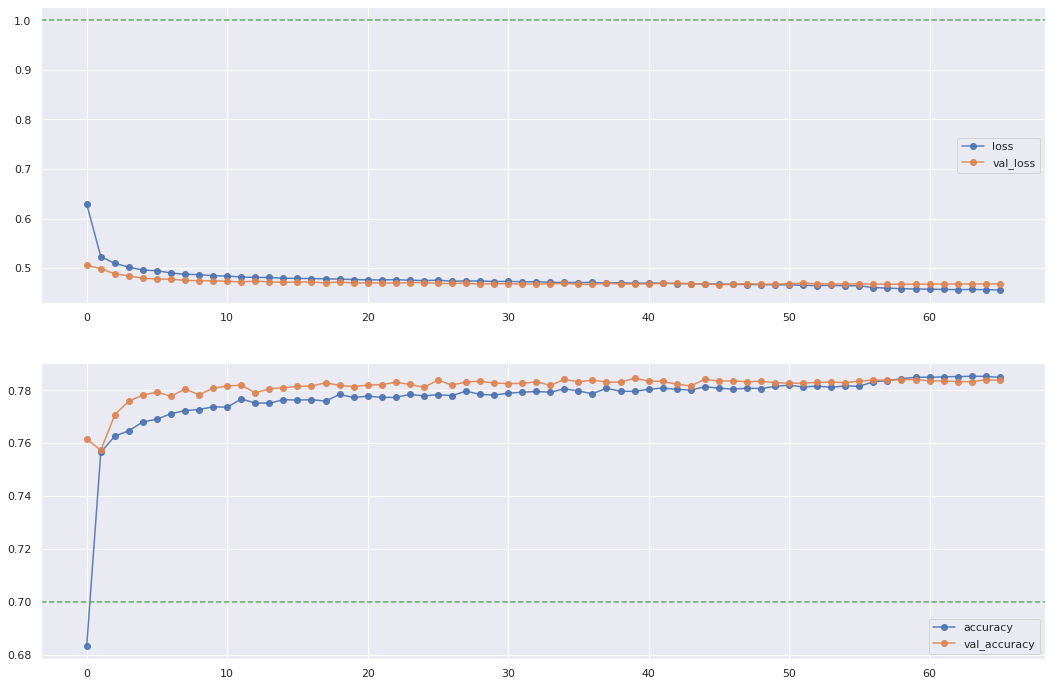

In [20]:
# Apenas para acompanhar o resultado visual
# Exibir o treinamento somente do primeiro kfold
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plt.plot(models_nn[0].history.history["loss"], "o-", alpha=.9, label="loss")
plt.plot(models_nn[0].history.history["val_loss"], "o-", alpha=.9, label="val_loss")
plt.axhline(1, linestyle="--", c="C2")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(models_nn[0].history.history["categorical_accuracy"], "o-", alpha=.9, label="accuracy")
plt.plot(models_nn[0].history.history["val_categorical_accuracy"], "o-", alpha=.9, label="val_accuracy")
plt.axhline(.7, linestyle="--", c="C2")
plt.legend()
plt.show()

# Previsões

In [21]:
# Criar um dataset somente com as colunas mais importantes conforme Feature Selection
new_test = teste.loc[:,best_features['Feature']]

# Padronizando os dados de treino
new_test = scaler.fit_transform(new_test)

new_test.shape

(114393, 25)

In [22]:
# Funcao para realizar as previsoes baseado em todos os modelos do Kfold
def predict_proba(model, x, batch_size=32, verbose=0):
    preds = model.predict(x, batch_size, verbose)
    if preds.min() < 0. or preds.max() > 1.:
        warnings.warn('Network returning invalid probability values.')
    return preds

def predict(x_te, models_nn):
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = predict_proba(m, x_te, batch_size=1024)
        else:
            y_pred_nn += predict_proba(m, x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    return y_pred_nn

In [23]:
# Realizando as previsões no dataset de teste
test_pred = predict(new_test, models_nn)
test_pred[:,1]

array([0.35087687, 0.8501545 , 0.86869085, ..., 0.89973706, 0.86728066,
       0.4841927 ], dtype=float32)

# Submissão

In [24]:
# Carrega o dataset de exemplo de submission e carrega as previsões das probabilidades
#submission = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/sample_submission.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = test_pred[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.350877
1,1,0.850155
2,2,0.868691
3,7,0.645837
4,10,0.816073


In [25]:
# Gera o arquivo de saída para submeter no Kaggle
submission.to_csv('../submission/submission_nn_v1.0.2.csv', index=False)

In [26]:
# Apenas para visualizar a distribuição das previsões
submission['PredictedProb'].value_counts(normalize=True)

0.836056    0.000026
0.941955    0.000026
0.963833    0.000026
0.933647    0.000026
0.950567    0.000026
              ...   
0.926571    0.000009
0.926571    0.000009
0.867957    0.000009
0.702730    0.000009
0.795499    0.000009
Name: PredictedProb, Length: 113252, dtype: float64

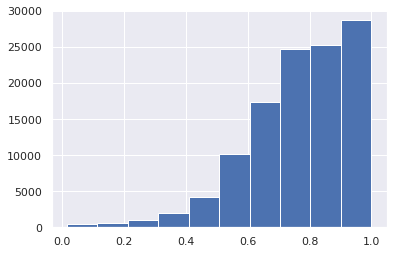

In [27]:
# Histograma com as previsões
plt.hist(submission.PredictedProb)
plt.show()

In [ ]:
### Continua....